In [1]:
import numpy as np
import os
import sys
import PIL.Image as Image
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   

The code will run on GPU.


<h1> Train a convolutional neural network that can classify single digits

<li>First training a CNN that can identify digits (if they are present).</li>
<li>We use CIFAR10 to train the network on non digit images.</li>
<li>The non digit class is represented by 10

In [ ]:
batch_size = 64
size = 32

transformer_svhn = transforms.Compose([
    transforms.Grayscale(3),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize([.5,.5,.5], [.5,.5,.5])
])

transformer_cifar = transforms.Compose([
    transforms.Grayscale(3),
    transforms.RandomResizedCrop((size,size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([.5,.5,.5], [.5,.5,.5])
])

# loading SVHN
svhn = datasets.SVHN('./data', download=True, transform=transformer_svhn)
svhn_loader = DataLoader(svhn, batch_size=batch_size, shuffle=True, num_workers=3)

# loading CIFAR10
cifar = datasets.CIFAR10("./data", download=True, transform=transformer_cifar)
cifar.targets = [10] * len(cifar.targets) #switching all label to 10, meaning "no digit"
cifar_loader = DataLoader(cifar, batch_size=batch_size, shuffle=True, num_workers=3)

In [ ]:
print("Length CIFAR10: {}".format(len(cifar_loader.dataset)))
print("Length SVHN: {}".format(len(svhn_loader.dataset)))

In [ ]:
# concatenating both dataset in order to create the final set
final_set = cifar + svhn

train_size = int(0.8 * len(final_set))
test_size = len(final_set) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(final_set, [train_size, test_size])

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size)

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size)

In [ ]:
# computing class weights
dic_weights = {i: 0 for i in range(11)}
for _, label in train_dataset:
    dic_weights[label] += 1
    
print(dic_weights)

sum_dic = sum(dic_weights.values())
weights_ = [elt for elt in dic_weights.values()]

tensor_weight = torch.tensor(weights_, dtype=torch.float32).to(device)

In [ ]:
# ploting images of the dataset
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(range(11)[labels[i].item()])
    plt.axis('off')

In [3]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU(),
                nn.Dropout(),
                nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.Dropout(),
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU())

        self.fully_connected = nn.Sequential(
            nn.Conv2d(32,500, kernel_size=16),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(500, 500, kernel_size=1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(500, 11, kernel_size=1),
            nn.ReLU(),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.convolutional(x)
        #reshape x so it becomes flat, except for the first dimension (which is the minibatch)
        x = self.fully_connected(x)
        return x

In [ ]:
def train_digit_classifier(model, optimizer, num_epochs=5):
    train_acc_all, test_acc_all = [], []
    
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        
        train_correct, test_correct = 0, 0
        model.train()
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data = data.to(device)
            target = target.to(device)
            
            # set the parameter gradients to zero
            optimizer.zero_grad()
            
            output = model(data).squeeze()
            
            loss_size = F.nll_loss(torch.log(output), target, weight=tensor_weight)
            loss_size.backward()
            optimizer.step()
            
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().item()
        
        model.eval()
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            
            with torch.no_grad(): # desactivating backpropagation
                output = model(data).squeeze()
            
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().item()
        
        train_acc = train_correct / train_size
        test_acc = test_correct / test_size
        print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))
        
        train_acc_all.append(train_acc)
        test_acc_all.append(test_acc)
    
    return train_acc_all, test_acc_all

In [ ]:
model = Network()
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=.1)

train_acc = train_digit_classifier(model, optimizer, num_epochs=20)

In [ ]:
torch.save(model.state_dict(), "digit_classifier_weighted.pth")

<hr>

<h1> Implementation of digit detection

In [5]:
def get_box_boundaries_around_digits(tensor_image, output):
    '''Return the box boundaries of windows that contain images
    Note: the axis are reverted like this:
                                    ---------> x
                                    |
                                    |
                                    |
                                    |
                                    V
                                    y               '''
    _, b, h = tensor_image.squeeze().shape
    
    scores = output.max(1).values
    scores = scores.tolist()[0]
    scores = [item for sublists in scores for item in sublists]
    
    predictions = output.argmax(1)
    list_predictions = predictions.tolist()[0]
    list_predictions = [item for sublist in list_predictions for item in sublist]
    
    b_window = 32
    h_window = 32
    
    coordinates, predicts, list_scores = [], [], []
    index = 0
    for y in range(h_window, h + 2, 2):
        for x in range(b_window, b + 2, 2):
            prediction = list_predictions[index]
            if prediction != 10:
                x_left, x_right = x - b_window, x
                x_right = x
                y_top = y - h_window
                y_bottom = y
                coordinates.append((x_left, x_right, y_top, y_bottom))
                predicts.append(prediction)
                list_scores.append(scores[index])
            index += 1

    return coordinates, predicts, list_scores

In [6]:
def rescale_bounding_boxes(bounding_box, inital_size_img: 'tuple', size: 'tuple'):
    '''Rescaling a bounding box to the initial image size and ratio'''
    x1, x2, y1, y2 = bounding_box
    h_init, w_init = inital_size_img
    h, w = size
    
    w_ratio = w / w_init
    h_ratio = h / h_init
    
    x1 = x1 * w_ratio
    x2 = x2 * w_ratio
    y1 = y1 * h_ratio
    y2 = y2 * h_ratio
    
    return (x1, x2, y1, y2)

In [7]:
def iou(coord_box1, coord_box2):
    '''Function returning the Jaccard index of two bounding box
    Parameters: tuples containing the positions of the box corner'''
    x_left1, x_right1, y_top1, y_bottom1 = coord_box1
    x_left2, x_right2, y_top2, y_bottom2 = coord_box2
    
    dx = min(x_right1, x_right2) - max(x_left1, x_left2)
    dy = min(y_bottom1, y_bottom2) - max(y_top1, y_top2)

    if (dx >= 0) and (dy >= 0):
        intersection = dx * dy
    else:
        intersection = 0
      
    area1 = (x_right1 - x_left1) * (y_bottom1 - y_top1)
    area2 = (x_right2 - x_left2) * (y_bottom2 - y_top2)
    union = area1 + area2 - intersection 
    
    return intersection / union

In [27]:
def nms(coord, labels, scores, threshold=.5):
    '''Implementation of Non-Max suppression'''
    coord_nms  = []
    labels_nms = []
    for i in range(len(coord)):            
        discard = False 
        for j in range(len(coord)):
            if (labels[i] == labels[j]) and (j != i):
                iou_ = iou(coord[i], coord[j])
                if iou_ > threshold:
                    if scores[j] > scores[i]:
                        discard = True
                        
        if not discard and scores[i] > .9:
            coord_nms.append(coord[i])
            labels_nms.append(labels[i])
            

    return coord_nms, labels_nms

In [9]:
class SVHN_(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/scratch/SVHN'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        list_files = os.listdir(data_path)
        self.image_paths = [os.path.join(data_path, file) for file in list_files]
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        X = self.transform(image)
        return X

<hr>

Loading data

In [49]:
batch_size = 64
size=300
height=300
width= 300

transformer_svhn_test = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((height, width)),
    transforms.CenterCrop((size, size)),
    transforms.ToTensor(),
    transforms.Normalize([.5,.5,.5], [.5,.5,.5])
])

SVHN_test = SVHN_(train=False, transform=transformer_svhn_test)
SVHN_test_loader = DataLoader(SVHN_test, batch_size=batch_size, shuffle=False, num_workers=3)

Loading model

In [50]:
torch.cuda.empty_cache() # freeing reusable memory

model = Network()
model.to(device)
model.load_state_dict(torch.load("digit_classifier_gray_scale_weighted.pth"));

Feeding the model with one image

In [51]:
# loading random image from the test loader and converting it to 
# a batch to be able to put it in the mode
image = next(iter(SVHN_test_loader))[15]
image_tensor = image.unsqueeze(0)
image_tensor = image_tensor.to(device)

model.eval()
output = model(image_tensor)

In [53]:
# applying IoU with a suitable threshold to find a digit correct.
coord_, labels_, scores_ = get_box_boundaries_around_digits(image_tensor, output)

final_coord, final_label = nms(coord_, labels_, scores_)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


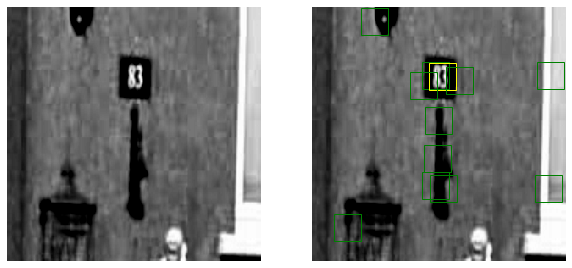

In [54]:
color_rectangle = {
    0: "yellow", 1: "green", 2: "blue", 3: "pink", 4: "red",
    5: "white", 6: "cyan", 7: "purple", 8: "orange", 9: "grey"
}

f = plt.figure(figsize=(10,5))
plt.tight_layout()

ax = f.add_subplot(121)
ax.imshow(np.swapaxes(np.swapaxes(image.numpy(), 0, 2), 0, 1))
ax.axis("off")

ax2 = f.add_subplot(122)
ax2.imshow(np.swapaxes(np.swapaxes(image.numpy(), 0, 2), 0, 1))
ax2.axis("off")

for (coord, label) in zip(final_coord, final_label):
    x_left, x_right, y_top, y_bottom = coord
    rect = patches.Rectangle((x_left,y_top),32,32,linewidth=1,edgecolor=color_rectangle[label],facecolor='none')
    ax2.add_patch(rect)
    
# plt.savefig("predictions_digit_gray_unnormalized.png")

In [ ]:
fig, ax = plt.subplots(1)

ax.imshow(np.swapaxes(np.swapaxes(image.numpy(), 0, 2), 0, 1))
ax.axis("off")

for elt in coord_:
    x_left, x_right, y_top, y_bottom = elt
    rect = patches.Rectangle((x_left,y_top),32,32,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
# plt.savefig("bounding_boxes_gray_normalized.png")

In [ ]:
def plot_detected_digits(number_images=50, shuffle=False):

    images = next(iter(SVHN_test_loader))

    for image in images:
        image_tensor = image.unsqueeze(0)
        image_tensor = image_tensor.to(device)

        model.eval()
        output = model(image_tensor)

        # applying IoU with a suitable threshold to find a digit correct.
        coord_, labels_ = get_box_boundaries_around_digits(image_tensor, output.argmax(1))

        scores_ = output.max(1).values
        scores_ = scores_.tolist()[0]
        scores_ = [item for sublists in scores_ for item in sublists]

        final_coord = nms(coord_, labels_, scores_)

        fig, ax = plt.subplots(1)

        ax.imshow(np.swapaxes(np.swapaxes(image.numpy(), 0, 2), 0, 1))
        ax.axis("off")

        for coord, label in final_coord:
            x_left, x_right, y_top, y_bottom = coord
            rect = patches.Rectangle((x_left,y_top),32,32,linewidth=1,edgecolor=color_rectangle[label],facecolor='none')
            ax.add_patch(rect)

        plt.show()

<hr>

<h2> Add multi-scale images

In [13]:
def rescale_image(image, sizes=[(200,200), (250,200), (200,250), (300, 250), (250, 300), (300, 300), (300, 200), (200, 300)], max_size=300):
    '''Function returning a list of resized images
    Parameters:
    image: Tensor
    sizes: list of tuples
    '''
    _, h_init, w_init = image.shape
    list_images = []
    
    img_PIL = transforms.ToPILImage()(image)
    for (h, w) in sizes:
        img = torchvision.transforms.Resize([h,w])(img_PIL)
        pad_h, pad_w = int((max_size - h) / 2), int((max_size - w) / 2)
        
        img = torchvision.transforms.Pad((pad_w, pad_h))(img)
        img = torchvision.transforms.ToTensor()(img)
        
        list_images.append(img)
        
    tensor_images = torch.stack(list_images)
    return tensor_images, (h_init, w_init)

In [20]:
def get_box_boundaries_around_digits_bis(tensor_image, output):
    '''Return the box boundaries of windows that contain images
    Note: the axis are reverted like this:
                                    ---------> x
                                    |
                                    |
                                    |
                                    |
                                    V
                                    y               '''
    _, b, h = tensor_image.squeeze().shape
    
    scores = output.max(0).values
    scores = scores.tolist()
    scores = [item for sublists in scores for item in sublists]
    
    list_predictions = output.argmax(0)
    list_predictions = list_predictions.tolist()
    list_predictions = [item for sublist in list_predictions for item in sublist]
    
    b_window = 32
    h_window = 32
    
    coordinates, predicts, list_scores = [], [], []
    index = 0
    for y in range(h_window, h + 2, 2):
        for x in range(b_window, b + 2, 2):
            prediction = list_predictions[index]
            if prediction != 10:
                x_left, x_right = x - b_window, x
                x_right = x
                y_top = y - h_window
                y_bottom = y
                coordinates.append((x_left, x_right, y_top, y_bottom))
                predicts.append(prediction)
                list_scores.append(scores[index])
            index += 1

    return coordinates, predicts, list_scores

In [55]:
# list of sizes
sizes = [(200,200), (250,200), (200,250), (300,250), 
         (250,300), (300,300), (300,200), (200,300),
         (150,150), (150,200), (200,150), (100,100),
         (150,300), (300,150)]

# loading image and "creating" the resized ones
image = next(iter(SVHN_test_loader))[11]
images, init_size = rescale_image(image, sizes)
image_tensor = images.to(device) # shape len(size) * 3 * size * size

# evaluating model those images
model.eval()
output = model(image_tensor)

coord_boxes, label_boxes, score_boxes = [], [], []
# looping through all scaled images
for i, (img_tensor, size) in enumerate(zip(output, sizes)):
    output_image = output[i]
    coords, labels, scores = get_box_boundaries_around_digits_bis(img_tensor, output_image)
    for (coord, label, score) in zip(coords, labels, scores):
        rescaled_coord = rescale_bounding_boxes(coord, init_size, size)
        coord_boxes.append(rescaled_coord)
        label_boxes.append(label)
        score_boxes.append(score)
        
# removing the unwanted boxescd D
final_coord, final_label = nms(coord_boxes, label_boxes, score_boxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


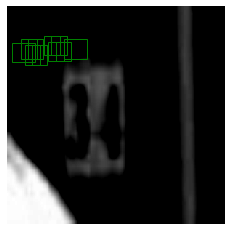

In [48]:
color_rectangle = {
    0: "yellow", 1: "green", 2: "blue", 3: "pink", 4: "red",
    5: "white", 6: "cyan", 7: "purple", 8: "orange", 9: "grey"
}

fig, ax = plt.subplots(1)

ax.imshow(np.swapaxes(np.swapaxes(image.numpy(), 0, 2), 0, 1))
ax.axis("off")

for (coord, label) in zip(final_coord, final_label):
    x_left, x_right, y_top, y_bottom = coord
    box_w = x_right - x_left
    box_h = y_bottom - y_top
    rect = patches.Rectangle((x_left,y_top),box_w,box_h,linewidth=1,edgecolor=color_rectangle[label],facecolor='none')
    ax.add_patch(rect)